In [2]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.3}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


In [74]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


with sqlite3.connect("games") as con:
    con.row_factory = dict_factory
    res = con.execute(
        """
        SELECT 
            g.result,
            m.eval,
            m.ply,
            m.material_white - m.material_black as balance
        FROM 
            games g INNER JOIN moves m 
            ON g.url = m.url
        WHERE
            g.result != 3
            AND m.eval is not NULL
            AND m.eval < 9900
            AND m.eval > -9900
        """
    )
    df = pd.DataFrame(res)
con.close()


In [97]:
random_state = 42

features = ["eval", "ply"]
X = df.loc[:, features]
y = df.result

classifier = LogisticRegressionCV(
    # Cs=50,
    random_state=random_state,
    n_jobs=-1,
    # penalty="elasticnet",
    # solver="saga",
    # l1_ratios=np.linspace(0, 1, num=20),
    # multi_class="ovr",
    class_weight="balanced",
    # fit_intercept=False,
)
scaler = StandardScaler()
model = make_pipeline(scaler, classifier)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, stratify=y
)


<AxesSubplot: xlabel='eval', ylabel='result'>

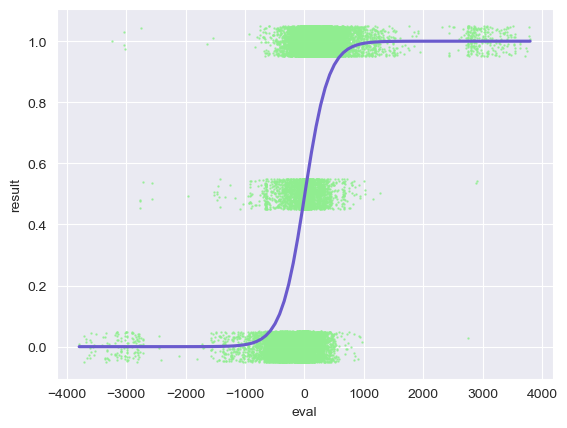

In [98]:
sns.regplot(
    data=(df + 1) / 2,
    x="eval",
    y="result",
    y_jitter=0.05,
    x_jitter=0.2,
    logistic=True,
    n_boot=1,
    ci=1,
    scatter_kws={"s": 0.5, "color": "lightgreen"},
    color="slateblue",
)


In [99]:
model.fit(X_train, y_train)

print(f"Accuracy: \n {model.score(X_test, y_test)}")
coefs = (
    model.named_steps["logisticregressioncv"].coef_
    / model.named_steps["standardscaler"].scale_
)
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["logisticregressioncv"].coef_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["logisticregressioncv"].C_
cs


Accuracy: 
 0.5615712814476975
Coefficients: 
 [[-0.00185 -0.00921]
 [-8.47e-05 0.0171]
 [0.00194 -0.00791]]
Intercept: 
 [[-1.32 -0.29]
 [-0.0603 0.54]
 [1.38 -0.249]]


array([0.359, 0.359, 0.359])

<AxesSubplot: xlabel='ply', ylabel='eval'>

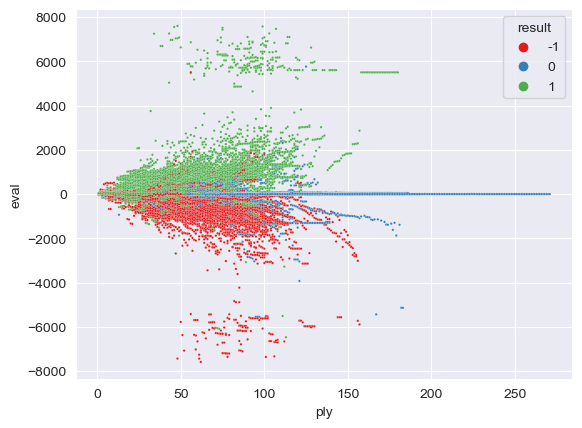

In [100]:
sns.scatterplot(
    df,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)


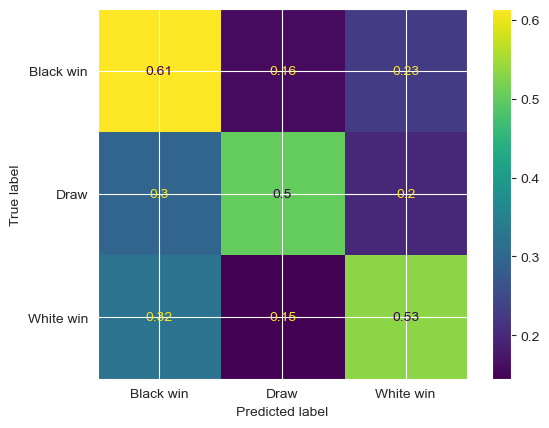

In [104]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    normalize="true",
    display_labels=[
        "Black win",
        "Draw",
        "White win",
    ],
)
